# Simulated Annealing - Programming Example

In [1]:
import csv
import sys
import math
import random
import time

import requests
from io import StringIO

import matplotlib.pyplot as plt

In [2]:
distances_pair = []

### Prerequisites

In [3]:
class City:
    """
    Store information regarding a city, including name and gps coordinates.
    """

    def __init__(self, name='', index=0, description='', latitude=0, longitude=0):
        self.name = name
        self.description = description
        self.latitude = latitude
        self.longitude = longitude
        self.index = index

    def __str__(self):
        return '%s %d %s %f %f' % (self.name, self.index, self.description, self.latitude, self.longitude)

    def __repr__(self):
        return self.__str__()

    def compute_distance_to_city_in_km(self, city):
        """Distance to another city using Haversine formula."""
        lat = math.radians(self.latitude - city.latitude)
        long = math.radians(self.longitude - city.longitude)
        a = math.pow(math.sin(lat/2), 2) \
           + math.cos(math.radians(self.latitude)) * math.cos(math.radians(city.latitude)) * pow(math.sin(long/2), 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        radius_earth = 6378.7 # in kilometers
        return radius_earth * c

    def distance_to_city_in_km(self, city):
        """Distance to another city using pre-computed distance."""
        global distances_pair
        if self.index != city.index:
            indices = [self.index, city.index]
            return distances_pair[max(indices)][min(indices)]
        return 0

In [4]:
def read_cities(url):
    """
    Read city data from a CSV file hosted online.
    """
    response = requests.get(url)
    if response.status_code != 200:
        # If the request was unsuccessful, raise an exception
        raise Exception("Failed to fetch data from URL")

    # Use StringIO to create a file-like object from the response content
    csv_content = StringIO(response.text)

    # Read CSV content using csv.reader
    reader = csv.reader(csv_content)

    # Skip header if needed
    next(reader)  # Skip header row if it exists

    # Parse rows and create City objects
    cities = []
    for index, row in enumerate(reader):
        # Adjust indexing if your CSV structure differs
        city = City(row[2], index, row[3], float(row[0]), float(row[1]))
        cities.append(city)

    return cities

In [5]:
def compute_distance_pairs(cities):
    """
    Compute all distance pairs.
    /!\ IMPORTANT: The cities must be ordered by their indices in the list.
    """
    global distances_pair
    for city_from in cities:
        distances_pair.append([0 for r in range(city_from.index)]) # create
        for city_to in cities[:city_from.index]:
            distances_pair[city_from.index][city_to.index] = city_from.compute_distance_to_city_in_km(city_to)


def total_distance_in_km(cities):
    distances = [cities[index].distance_to_city_in_km(cities[(index + 1) % len(cities)]) for index in range(len(cities))]
    return sum(distances)

In [6]:
def plot_cities(cities, figure_id):
    """Plot the cities on a plan."""
    fig_map = plt.figure(figure_id, figsize=(15, 9))
    ax_map = fig_map.add_subplot(111)

    cities_x = [city.longitude for city in cities + [cities[0]]]
    cities_y = [city.latitude for city in cities + [cities[0]]]

    link = '-'
    ax_map.plot(cities_x, cities_y, 'go' + link)
    ax_map.grid()

    spacing = math.fabs(min(cities_x) - max(cities_x)) * .1
    ax_map.set_xlim(min(cities_x) - spacing, max(cities_x) + spacing * 3)
    ax_map.set_ylim(min(cities_y) - spacing, max(cities_y) + spacing)

    for index, city in enumerate(cities):
        #ax_map.text(city.longitude, city.latitude,'%d: %s' % (index + 1, city.name),
                    #withdash = True,
                    #dashdirection = 1,
                    #dashlength = 30,
                    #rotation = 0,
                    #dashrotation = 15,
                    #dashpush = 10
        #          )
        ax_map.annotate('%d: %s' % (index + 1, city.name),
                xy=(city.longitude, city.latitude),
                xytext=(city.longitude + 0.1, city.latitude + 0.1),  # Adjust these values for distance from the dot
                arrowprops=dict(arrowstyle="->"))
    return ax_map

In [7]:
def plot_distances(distances_current, figure_id, distances_best, ids_iteration, nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end):
    """Plot the evolution of the distance metrics."""
    # plot distances
    fig_distances = plt.figure(figure_id)
    ax_distances = fig_distances.add_subplot(111)
    line_current = ax_distances.plot(distances_current, linewidth=1)
    line_best = ax_distances.plot(distances_best, 'r', linewidth=2)
    ax_distances.set_title('Simulated annealing for %d cities on %d iteration(s)\nc_factor: %.4f, t_start: %g, t_end: %.4f' % (nb_cities, nb_iterations, cooling_factor, temperature_start, temperature_end))

    # plot iteration steps
    y_min = min(distances_current)
    y_max = max(distances_current)
    line_iteration = None

    for step in ids_iteration[:-1]:
        line_iteration = ax_distances.plot([step, step], [y_min, y_max], 'g', linewidth=2)

    ax_distances.set_xlabel('Steps')
    ax_distances.set_ylabel('Distance (km)')

    index_legend = 3 if len(ids_iteration) > 1 else 2
    plt.legend( (line_current, line_best, line_iteration)[:index_legend],
                ('Tested distance', 'Shortest distance', 'Restart')[:index_legend],
                loc='upper right' )

In [8]:
def compute_swap_indices(index, nb_cities):
    index_previous = (index - 1 + nb_cities) % nb_cities
    index_next = (index + 1) % nb_cities
    return (index_previous, index_next)

In [9]:
def distance_swap(cities, index_a, index_b):
    """Compute the distance inferred by the two given indices."""
    index_A = min(index_a, index_b)
    index_B = max(index_a, index_b)

    (index_A_previous, index_A_next) = compute_swap_indices(index_A, len(cities))
    (index_B_previous, index_B_next) = compute_swap_indices(index_B, len(cities))

    distances = []
    # These two distances are common to the two sub-cases
    distances.append(cities[index_A_previous].distance_to_city_in_km(cities[index_A]))
    distances.append(cities[index_B].distance_to_city_in_km(cities[index_B_next]))
    if index_A == index_B_previous:
        # B is following A in the list: the distance between A and B must not
        # be counted twice.
        # ---x---A---B---x---
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_B]))
    else:
        # B is not following A in the list: all distances must be counted
        # ---x---A---x--- ... ---x---B---x---
        distances.append(cities[index_A].distance_to_city_in_km(cities[index_A_next]))
        distances.append(cities[index_B_previous].distance_to_city_in_km(cities[index_B]))

    return sum(distances)


## Algorithm Implementation

In [10]:
def annealing(cities, temperature_begin=1.0e+300, temperature_end=.1, cooling_factor=.99, nb_iterations=1):
    """
    Simulated annealing function, implemented with acceptance probability from
    by Kirkpatrick et al., and with restart.

    distance_best:    best solution encountered so far
    distance_current: solution used in the current simulation
    distance_new:     solution computed from the random changes to current
    """

    cities_best = cities[:]
    distance_best = total_distance_in_km(cities_best)

    distances_current = []
    distances_best = []
    ids_iteration = []

    try:
        for iteration in range(nb_iterations):
            # the search is restarted at every iteration from
            # the best know solution
            temperature = temperature_begin
            cities_current = cities_best[:]
            distance_current = distance_best
            distance_new = distance_best
            cities_new = cities_best[:]

            step = 0
            while temperature > temperature_end:
                # compute the indices of the two cities to swap by random,
                # but never touch the first city (it does not need to change)
                index = random.sample(range(len(cities_new) - 1), 2)
                index[0] += 1
                index[1] += 1

                # optimize by recomputing only the changed distances
                swap_before = distance_swap(cities_new, index[0], index[1])
                cities_new[index[0]], cities_new[index[1]] = cities_new[index[1]], cities_new[index[0]]
                swap_after = distance_swap(cities_new, index[0], index[1])

                # compute the new distance
                # recomputing all is bad: distance_new = total_distance_in_km(cities_new)
                distance_new = distance_new - swap_before + swap_after

                # acceptance probability by Kirkpatrick et al.
                diff = distance_new - distance_current
                if diff < 0 or  math.exp( -diff / temperature ) > random.random():
                    cities_current = cities_new[:]
                    distance_current = distance_new
                else:
                    # reset cities and distance
                    distance_new = distance_current
                    cities_new = cities_current[:]

                # update the best if current solution is better
                # not part of the annealing itself, just used for the restart
                if distance_current < distance_best:
                    cities_best = cities_current[:]
                    distance_best = distance_current

                if True:
                    # if step % 100 == 0:
                    # uncomment to enable systematic sampling: 1 point every 100th
                    distances_current.append(distance_current)
                    distances_best.append(distance_best)
                temperature = temperature * cooling_factor
                step = step + 1

            ids_iteration.append(len(distances_current))

    except (KeyboardInterrupt):
        print("Interrupted on user demand.")
        print('performed iterations: %d' % iteration )

    return cities_best, distances_current, distances_best, ids_iteration

# Usage of Simulated Annealing

Starting simulated annealing
Improvement:                51 %
Time:                        0 sec
Initial distance:         1160 km
Optimal distance:          573 km


<ipython-input-7-a5278855e86f>:22: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend( (line_current, line_best, line_iteration)[:index_legend],


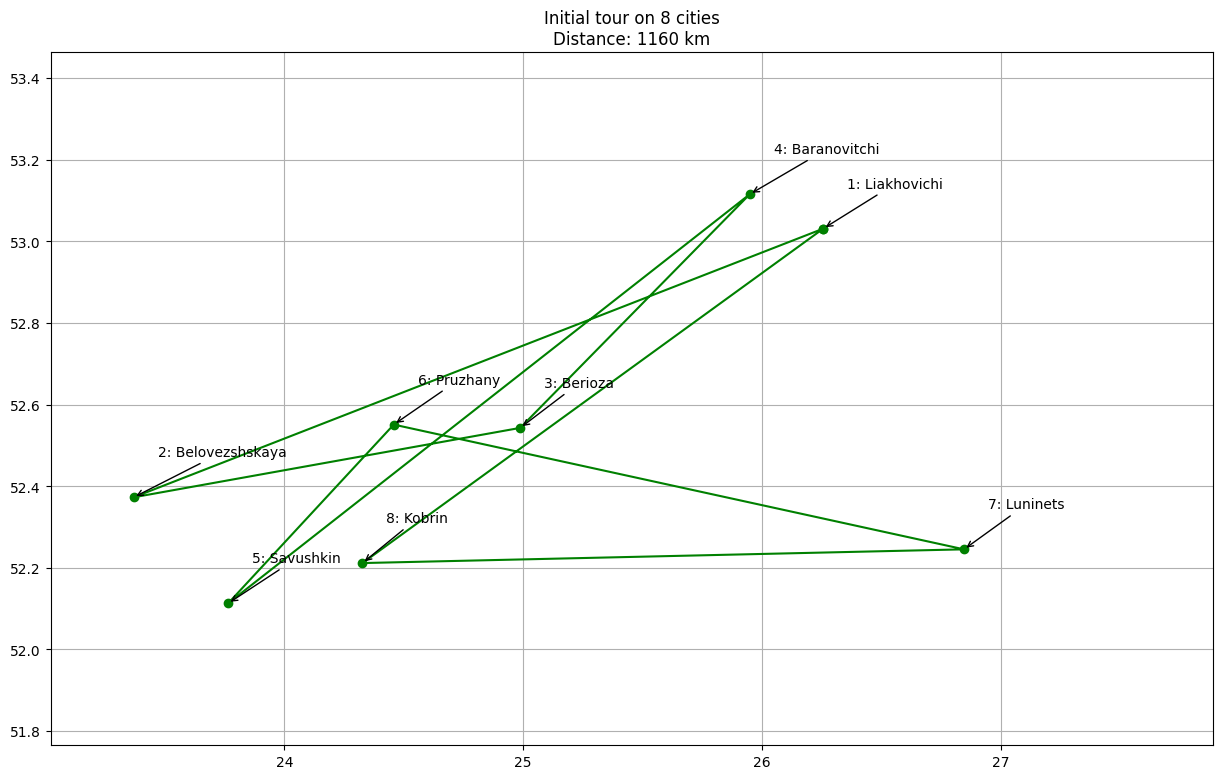

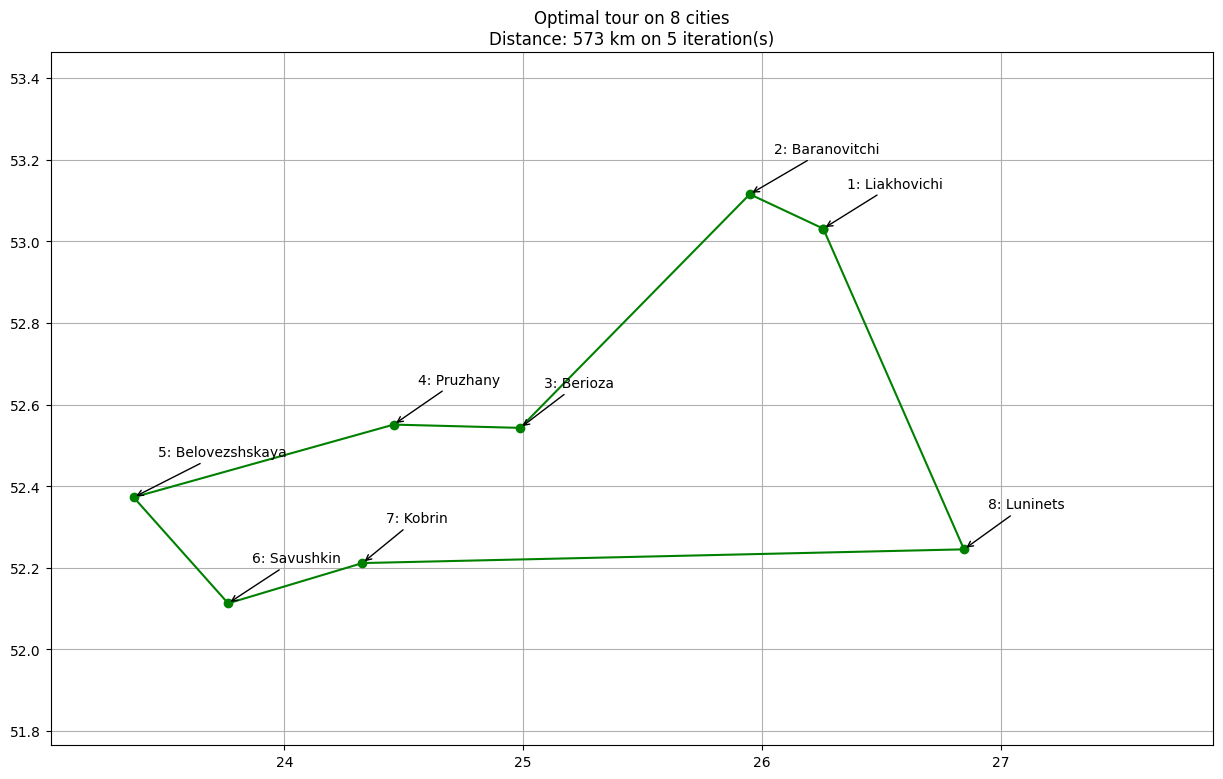

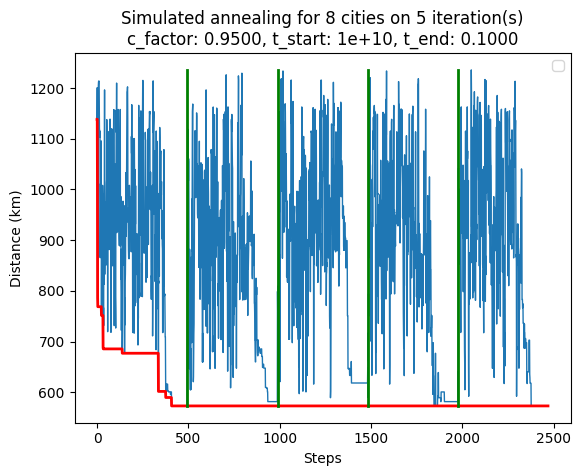

In [11]:
#input             = "https://gist.githubusercontent.com/lucastanger/bc5e458f07211193454ee4f194088d85/raw/b30ef66ad8d56ad495ca0144ae5060b41786bea1/gistfile1.csv"
input             = "https://gist.githubusercontent.com/lucastanger/5524284176bc524235ebf06ecc0aaf2c/raw/732958edd43038edba60bc0f6e254b0e3ec043c7/dairy_farms.csv"
plot              = "plot"
nb_iterations     = 5
nb_cities         = -1
cooling_factor    = .95
temperature_start = 1.0e+10
temperature_end   = .1
random_seed       = -1

if random_seed == -1:
    random.seed()
else:
    random.seed(random_seed)

time_begin = time.time()
cities = read_cities(input)
compute_distance_pairs(cities)

nb_cities = len(cities) if nb_cities <= 0 else nb_cities

print('Starting simulated annealing')

cities = cities[:nb_cities]
(cities_new, distances_current, distances_best, ids_iteration) = annealing(cities, temperature_start, temperature_end, cooling_factor, nb_iterations)
time_end = time.time()

distance_begin = total_distance_in_km(cities)
distance_end = total_distance_in_km(cities_new)
print('Improvement:          %8.0f %%'  % (100 * (distance_begin - distance_end) / distance_begin))
print('Time:                 %8.0f sec' % (time_end - time_begin))
print('Initial distance:     %8.0f km'  % distance_begin)
print('Optimal distance:     %8.0f km'  % distance_end)

ax_map = plot_cities(cities, 1)
ax_map.set_title('Initial tour on %d cities\nDistance: %.0f km' % (len(cities), distance_begin))

if nb_iterations:
    ax_map = plot_cities(cities_new, 2)
    ax_map.set_title('Optimal tour on %d cities\nDistance: %.0f km on %d iteration(s)' % (len(cities), distance_end, nb_iterations))
    plot_distances(distances_current, 3, distances_best, ids_iteration, len(cities), nb_iterations, cooling_factor, temperature_start, temperature_end)

plt.show()